In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.utils import to_categorical 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import keras.preprocessing
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Loading and reshaping data

In [2]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
y_train = to_categorical(train.pop("label"))
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
shape = (28, 28,1)
X_train = np.reshape(train.to_numpy(), (len(train), *shape))/255
X_test = np.reshape(test.to_numpy(), (len(test), *shape))/255

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


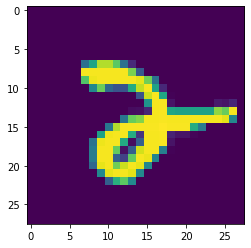

In [4]:
plt.imshow(X_train[34])
print(y_train[34])

# Modelling

In [5]:
from tensorflow.keras.layers.experimental import preprocessing

model = Sequential()
model.add(preprocessing.RandomFlip('horizontal', input_shape=[28,28,1])) # random flipping the images to teach cnn to ignore such transformations
model.add(preprocessing.RandomContrast(0.5))
model.add(Conv2D(filters=16, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D())
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2022-06-05 06:31:28.421637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 06:31:28.562294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 06:31:28.563810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 06:31:28.567273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 28, 28, 1)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0

In [6]:
# to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=500, callbacks=[early_stopping],
    verbose=1)

2022-06-05 06:31:31.928792: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-05 06:31:33.730563: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


68/68 [==============================] - 9s 16ms/step - loss: 1.0894 - accuracy: 0.6325 - val_loss: 1.9176 - val_accuracy: 0.2594
Epoch 2/50
68/68 [==============================] - 1s 10ms/step - loss: 0.4443 - accuracy: 0.8489 - val_loss: 2.2994 - val_accuracy: 0.1779
Epoch 3/50
68/68 [==============================] - 1s 10ms/step - loss: 0.3271 - accuracy: 0.8898 - val_loss: 2.4648 - val_accuracy: 0.1923
Epoch 4/50
68/68 [==============================] - 1s 10ms/step - loss: 0.2716 - accuracy: 0.9094 - val_loss: 1.9422 - val_accuracy: 0.3063
Epoch 5/50
68/68 [==============================] - 1s 10ms/step - loss: 0.2315 - accuracy: 0.9240 - val_loss: 1.2263 - val_accuracy: 0.5587
Epoch 6/50
68/68 [==============================] - 1s 10ms/step - loss: 0.1907 - accuracy: 0.9381 - val_loss: 0.6174 - val_accuracy: 0.8138
Epoch 7/50
68/68 [==============================] - 1s 10ms/step - loss: 0.1610 - accuracy: 0.9488 - val_loss: 0.2274 - val_accuracy: 0.9365
Epoch 8/50
68/68 [======

Best Validation Loss: 0.0420
Best Validation accuracy: 0.9881


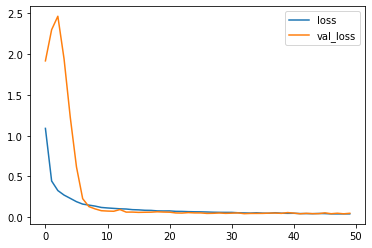

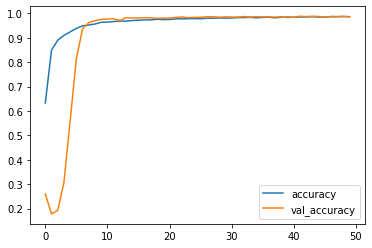

In [7]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [8]:
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
print(pred[34])
print(y_pred[34])

[1.8513876e-07 3.0095548e-11 2.9669841e-06 9.7057817e-10 2.1261220e-08
 2.2191269e-08 9.9999690e-01 1.2613889e-10 1.2236917e-08 2.6804474e-11]
6


In [9]:
submission = pd.DataFrame()
submission["ImageId"] = range(1, len(y_pred) + 1)
submission["Label"] = y_pred
submission.head(5)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [10]:
submission.to_csv('submission.csv', index = False)